<a href="https://colab.research.google.com/github/guevelel/COMP4449_Image_Classification/blob/main/P7_Plume_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP4449 Final - Term Project 7: Mystery at the Wildlife Preserve (Plume Analysis)
## Edward Guevel


####Goals

1- Characterize the sensors’ performance and operation. Are they all working properly at all times? Can you detect any unexpected behaviors of the sensors through analyzing the readings they capture?

2- Now turn your attention to the chemicals themselves. Which chemicals are being detected by the sensor group? What patterns of chemical releases do you see, as being reported in the data?

3- Which factories are responsible for which chemical releases? Carefully describe how you determined this using all the data you have available. For the factories you identified, describe any observed patterns of operation revealed in the data.

In [52]:
#QUESTIONS:
#aggregate sensor data avg rating per chemical per sensor
#How do you add overlaying plots in plotly?
#Does time of day matter, month to month, wind speed v. sensor
#Boxplots for sensor data to find outliers?

#Note meteorigical data is not always working, there are some missing dates? isin?
#Remove the sensor data that does not have an associated windspeed!
#Plot wind speed v. date?
#Revisit wind direction and sensor data not aligning on dates...
#
#Wind sensor is backwards... (North is South)
#Should we be running any ML algorithms? or just more of a data analysis task?
#high parts per million values?
#

#Regression of different wind speeds and directions and the sensor readings
#Factory is delivering toxic, they could be tampering with the sensors???
#Times during the day or during the night? (sensor tampering) - is something odd going on?
#PPM could be high or low? How do you decide to treat outliers (treat as errors, or treat as high reading)
#

In [53]:
!pip3 install dash --upgrade
!pip install jupyter-dash --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
#Import required libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import plotly.express as px
import plotly.io as pio
from dash import Dash
from dash import dcc, html
from dash import Input, Output
from jupyter_dash import JupyterDash
pio.renderers.default = "notebook_connected"


from google.colab import files
import io

In [55]:
#Upload files from computer:

uploaded = files.upload()

Saving MeteorologicalData.csv to MeteorologicalData (1).csv
Saving SensorData.csv to SensorData (1).csv


In [56]:
#Write files to pandas DF:
meteor = pd.read_csv('MeteorologicalData.csv')
#meteor = pd.read_csv(io.BytesIO(uploaded['MeteorologicalData.xlsx']))
sensor = pd.read_csv('SensorData.csv')

In [57]:
meteor.head()
meteor.describe()

Wind Direction  Wind Speed (m/s)  Unnamed: 3  Unnamed: 4
count      705.000000        705.000000         0.0         0.0
mean       236.467376          2.250355         NaN         NaN
std         79.310219          1.283297         NaN         NaN
min          0.100000          0.100000         NaN         NaN
25%        182.500000          1.200000         NaN         NaN
50%        252.200000          2.200000         NaN         NaN
75%        299.900000          3.100000         NaN         NaN
max        359.100000          6.800000         NaN         NaN

In [58]:
sensor.head()
sensor

Chemical  Monitor      Date Time    Reading
0      Methylosmolene        3     4/1/16 0:00  2.683820
1      Methylosmolene        7     4/1/16 0:00  2.630640
2        Chlorodinine        3     4/1/16 0:00  1.259170
3        Chlorodinine        7     4/1/16 0:00  0.943983
4             AGOC-3A        3     4/1/16 0:00  0.722303
...               ...      ...             ...       ...
79238         AGOC-3A        1  12/31/16 23:00  0.078266
79239  Methylosmolene        3  12/31/16 23:00  0.062784
79240         AGOC-3A        2  12/31/16 23:00  0.060814
79241     Appluimonia        7  12/31/16 23:00  0.039729
79242         AGOC-3A        7  12/31/16 23:00  0.014658

[79243 rows x 4 columns]

In [59]:
#meteor['Unnamed: 3'].values.sum()
meteor.drop(columns=['Unnamed: 3', 'Unnamed: 4'], inplace=True)
#sensor = sensor.rename(columns={'Date Time ': 'date'}, inplace=True)
sensor.rename(columns = {'Date Time ': 'date'}, inplace=True)

meteor.head()
sensor.head()

Chemical  Monitor         date   Reading
0  Methylosmolene        3  4/1/16 0:00  2.683820
1  Methylosmolene        7  4/1/16 0:00  2.630640
2    Chlorodinine        3  4/1/16 0:00  1.259170
3    Chlorodinine        7  4/1/16 0:00  0.943983
4         AGOC-3A        3  4/1/16 0:00  0.722303

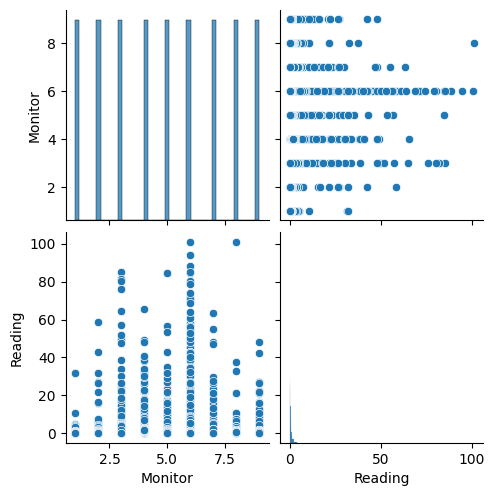

In [60]:
sns.pairplot(sensor)

In [61]:
#Create list of sensor coordinates:
sensor_coords = {1:[62,21],2:[66,35],3:[76,41],
                 4:[88,45],5:[103,43], 6:[102,22],
                 7:[89,3],8:[74,7],9:[119,42]}

#Append sensor_coords to sensor dataframe:
def add_x_coords(row):
  return sensor_coords[row['Monitor']][0]
def add_y_coords(row):
  return sensor_coords[row['Monitor']][1]
  
sensor['x'] = sensor.apply(lambda row: add_x_coords(row), axis=1)
sensor['y'] = sensor.apply(lambda row: add_y_coords(row), axis=1)

sensor.head()

Chemical  Monitor         date   Reading   x   y
0  Methylosmolene        3  4/1/16 0:00  2.683820  76  41
1  Methylosmolene        7  4/1/16 0:00  2.630640  89   3
2    Chlorodinine        3  4/1/16 0:00  1.259170  76  41
3    Chlorodinine        7  4/1/16 0:00  0.943983  89   3
4         AGOC-3A        3  4/1/16 0:00  0.722303  76  41

In [62]:
#Check for missing values:
#sensor.isnull().sum()
meteor.isnull().sum()

#Drop null values from Meteorological Data, since so few values:
meteor.dropna(axis=0, inplace=True)
meteor.isnull().sum()


Date                0
Wind Direction      0
Wind Speed (m/s)    0
dtype: int64

In [63]:
#Convert string dates to date-time objects:
sensor['date'] = pd.to_datetime(sensor['date'], format="%m/%d/%y %H:%M")

meteor['Date'] = pd.to_datetime(meteor['Date'] , format="%m/%d/%y %H:%M")

sensor.head()

Chemical  Monitor       date   Reading   x   y
0  Methylosmolene        3 2016-04-01  2.683820  76  41
1  Methylosmolene        7 2016-04-01  2.630640  89   3
2    Chlorodinine        3 2016-04-01  1.259170  76  41
3    Chlorodinine        7 2016-04-01  0.943983  89   3
4         AGOC-3A        3 2016-04-01  0.722303  76  41

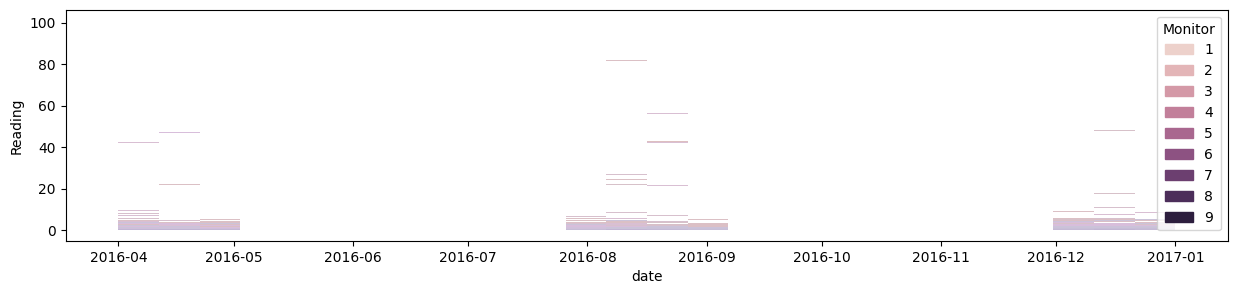

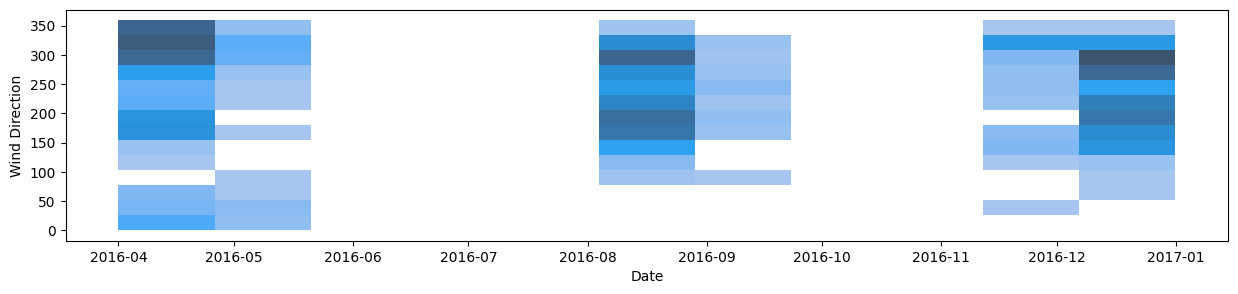

In [64]:
#Histogram of the sensor data:
plt.figure(figsize=(15,3))
sns.histplot(sensor, y=sensor['Reading'], x=sensor['date'], hue=sensor['Monitor'])
#sns.scatter
plt.show()

#Histogram of the Meteorological data:
plt.figure(figsize=(15,3))
sns.histplot(meteor, y=meteor['Wind Direction'], x=meteor['Date'])
#sns.scatter
plt.show()

In [65]:
#Add wind direction and speed as columns to sensor data:

meteor_dates = meteor['Date'].tolist()

def add_wind(row):
  if row['date'] in meteor_dates:
    return meteor.loc[meteor['Date'] == row['date']]['Wind Direction'].tolist()[0]
  else:
    if row['date'] - timedelta(hours=1) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=1))]['Wind Direction'].tolist()[0]
    if row['date'] - timedelta(hours=2) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=2))]['Wind Direction'].tolist()[0]

def add_windspeed(row):
  if row['date'] in meteor_dates:
    return meteor.loc[meteor['Date'] == row['date']]['Wind Speed (m/s)'].tolist()[0]
  else:
    if row['date'] - timedelta(hours=1) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=1))]['Wind Speed (m/s)'].tolist()[0]
    if row['date'] - timedelta(hours=2) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=2))]['Wind Speed (m/s)'].tolist()[0]
 
sensor['wind'] = sensor.apply(lambda row: add_wind(row), axis=1)
sensor['wind_speed'] = sensor.apply(lambda row: add_windspeed(row), axis=1)
sensor.sample(10)



Chemical  Monitor                date   Reading    x   y   wind  \
23741    Chlorodinine        5 2016-04-28 13:00:00  0.373503  103  43  329.1   
68326         AGOC-3A        6 2016-12-19 08:00:00  0.261084  102  22  308.5   
15866    Chlorodinine        2 2016-04-19 10:00:00  0.173159   66  35  344.6   
71731     Appluimonia        6 2016-12-23 07:00:00  0.541203  102  22  293.9   
67885  Methylosmolene        6 2016-12-18 20:00:00  0.439429  102  22  291.6   
35838         AGOC-3A        5 2016-08-12 16:00:00  0.490603  103  43  248.1   
59707     Appluimonia        8 2016-12-09 09:00:00  0.747116   74   7  283.2   
20916    Chlorodinine        3 2016-04-25 07:00:00  2.349180   76  41  293.8   
58147         AGOC-3A        4 2016-12-07 14:00:00  5.062630   88  45  144.5   
27553     Appluimonia        3 2016-08-03 00:00:00  0.673121   76  41    NaN   

       wind_speed  
23741         3.1  
68326         3.9  
15866         1.1  
71731         3.2  
67885         3.7  
35838         2.6  
59707         4.0  
20916         1.5  
58147         1.2  
27553         NaN

<Axes: >

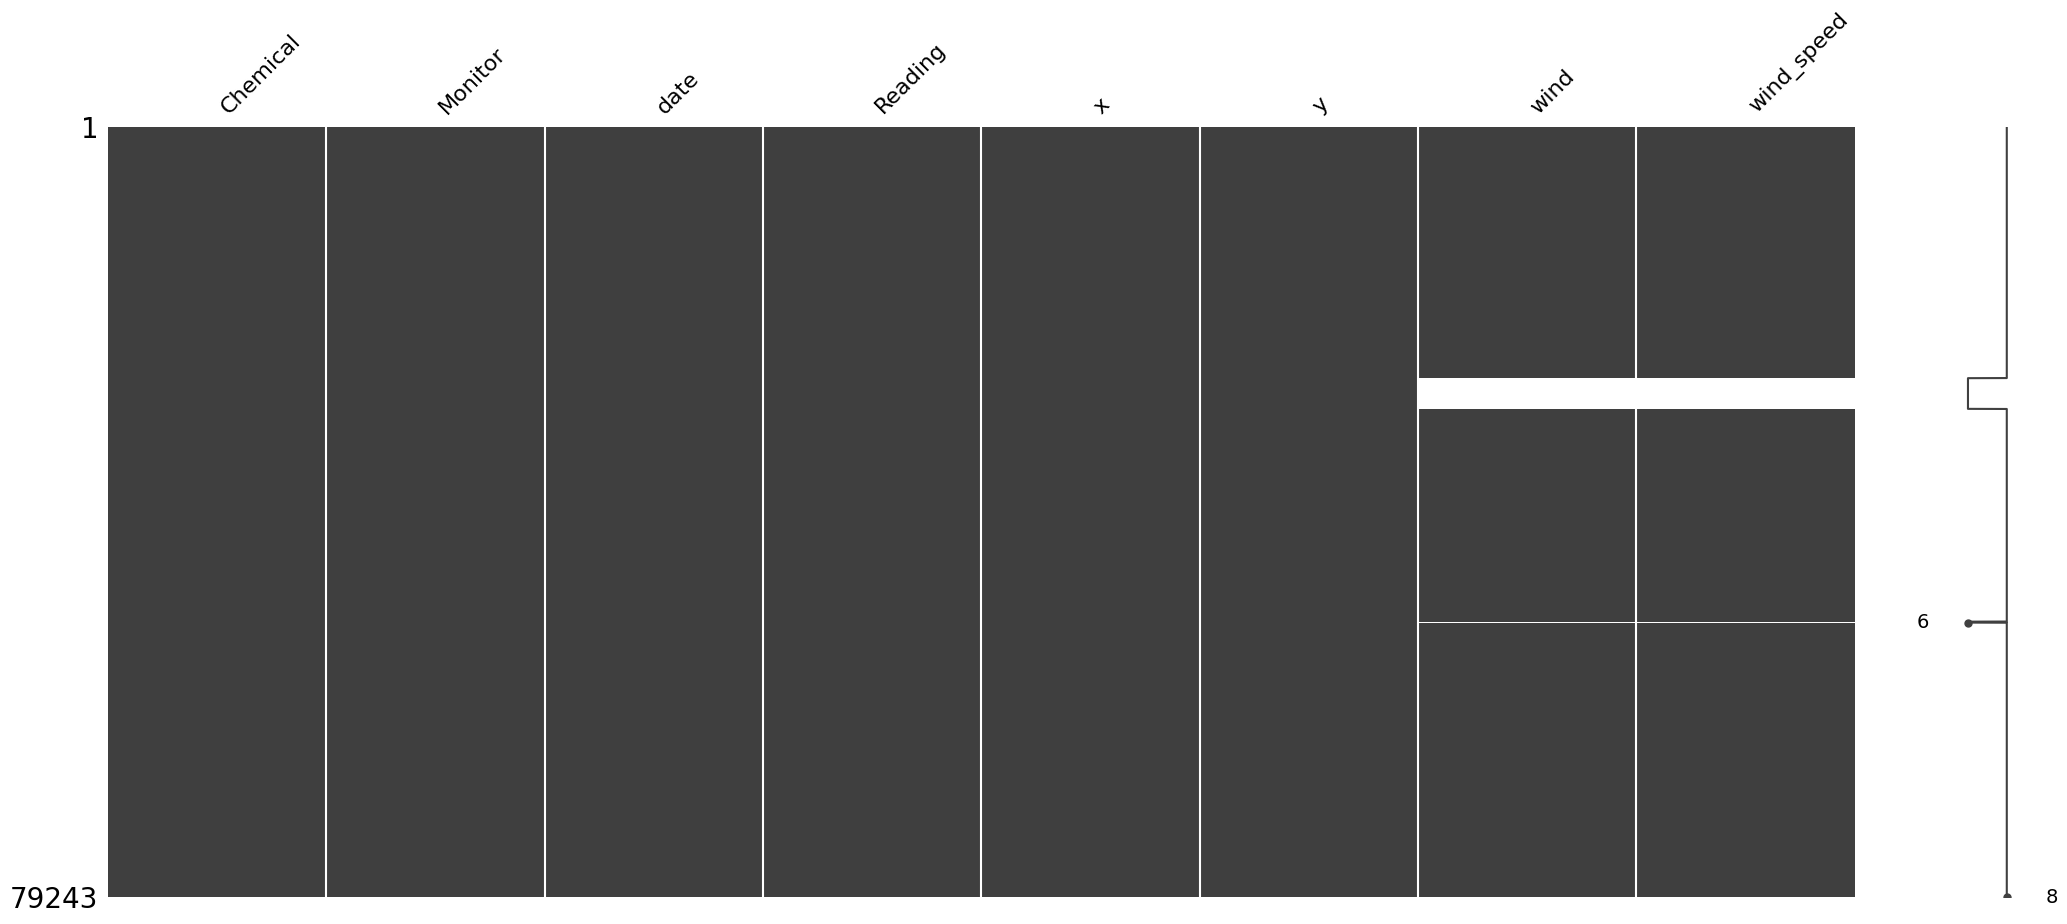

In [66]:
import missingno as msno
msno.matrix(sensor)

Note that the Meteorological Data is missing values at the beginning of August and at the beginning of December. Overall, it is not missing very much data

In [67]:
#

In [68]:
meteor.head(2)#

Date  Wind Direction  Wind Speed (m/s)
0 2016-04-01 00:00:00           190.5               4.0
1 2016-04-01 03:00:00           203.3               5.0

In [69]:
sensor.head(2)

Chemical  Monitor       date  Reading   x   y   wind  wind_speed
0  Methylosmolene        3 2016-04-01  2.68382  76  41  190.5         4.0
1  Methylosmolene        7 2016-04-01  2.63064  89   3  190.5         4.0

In [70]:
'''
#Histogram of the sensor data:
plt.figure(figsize=(15,6))
sns.histplot(sensor, y=sensor['Reading'], x=sensor['date'], hue=sensor['Monitor'])
#sns.scatter
plt.show()

#Histogram of the Meteorological data:
plt.figure(figsize=(15,6))
sns.histplot(meteor, y=meteor['Wind Direction'], x=meteor['Date'])
#sns.scatter
plt.show()
'''

"\n#Histogram of the sensor data:\nplt.figure(figsize=(15,6))\nsns.histplot(sensor, y=sensor['Reading'], x=sensor['date'], hue=sensor['Monitor'])\n#sns.scatter\nplt.show()\n\n#Histogram of the Meteorological data:\nplt.figure(figsize=(15,6))\nsns.histplot(meteor, y=meteor['Wind Direction'], x=meteor['Date'])\n#sns.scatter\nplt.show()\n"

In [71]:
#sns.pairplot(sensor)

We can see that the sensors were only collecting data in certain time ranges...

In [72]:
print(f"Null values after merging data: {sensor.isna().sum()}")

#We will drop the null values since 3278 is only 4% of the data set:
sensor.dropna(axis=0, inplace=True)
#sensor.isna().sum()

Null values after merging data: Chemical         0
Monitor          0
date             0
Reading          0
x                0
y                0
wind          3278
wind_speed    3278
dtype: int64


In [73]:
#look at april-may sensor data:
#import datetime
#apr_sensor = sensor[datetime.datetime.strptime(sensor["date"],"%d/%m/%Y") < datetime.date(5/1/2016)]
#apr_sensor.head()
apr_sensor = sensor.iloc[0:25847]
oct_sensor = sensor.iloc[25848:52525]
dec_sensor = sensor.iloc[52526:]

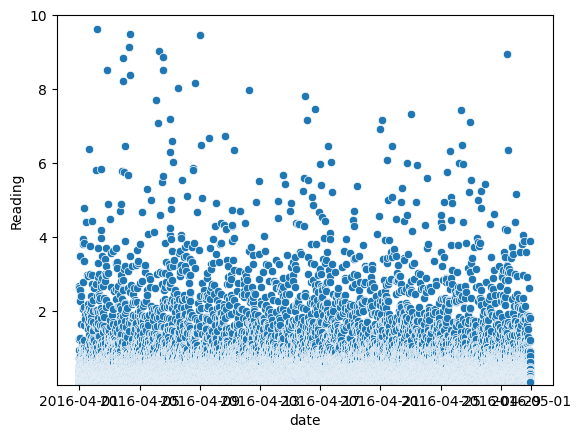

In [74]:
sns.scatterplot(apr_sensor, x=apr_sensor['date'],y=apr_sensor['Reading'])
plt.ylim(bottom = .01,top=10)
plt.show()

In [75]:
#temp = np.where(apr_sensor['Monitor']==1)
temp = apr_sensor[apr_sensor['Monitor']==1]
temp['date']

11      2016-04-01 00:00:00
13      2016-04-01 00:00:00
23      2016-04-01 00:00:00
35      2016-04-01 00:00:00
49      2016-04-01 01:00:00
                ...        
25810   2016-04-30 22:00:00
25826   2016-04-30 23:00:00
25831   2016-04-30 23:00:00
25839   2016-04-30 23:00:00
25843   2016-04-30 23:00:00
Name: date, Length: 2872, dtype: datetime64[ns]

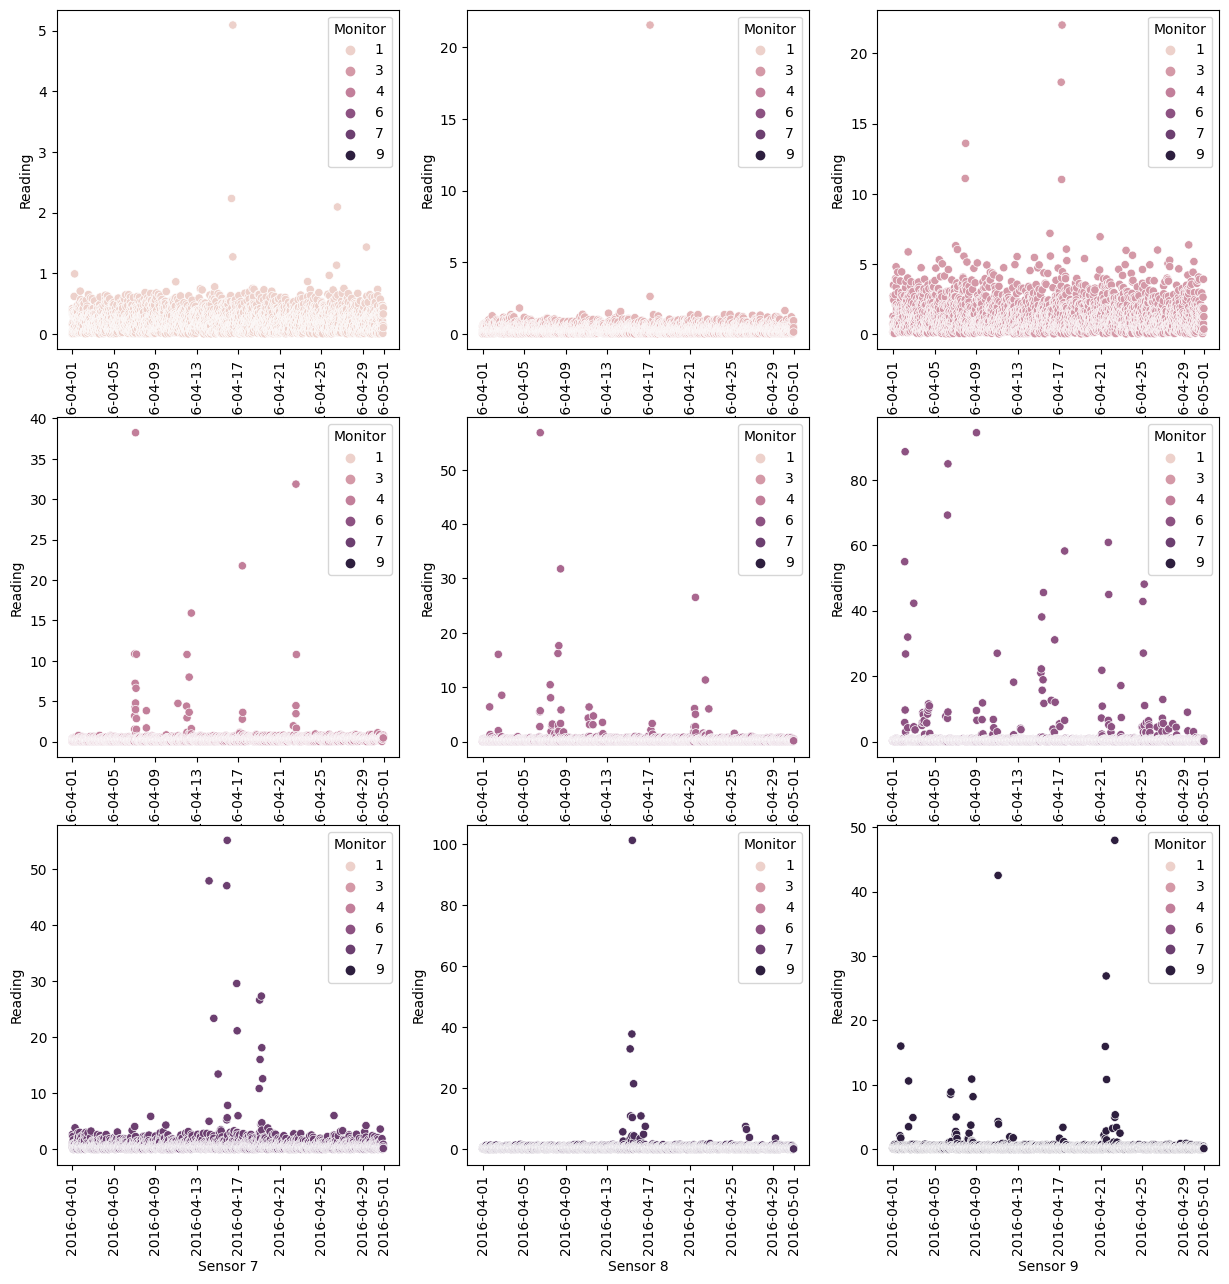

In [76]:
#Update headers, labels, and add graphs for the other two sensors

plt.figure(figsize=(15,15))
for i in range(1,10):
  plt.subplot(3,3,i)
  #plt.xticks([])
  #plt.yticks([])
  #plt.grid(False)
  temp = apr_sensor[apr_sensor['Monitor']==i]
  #apr_sensor
  sns.scatterplot(temp, x=temp['date'], y=temp['Reading'], hue=sensor['Monitor'])
  #titles = np.where(train['labels']==i)
  #index = titles[0][50]
  #plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(f'Sensor {i}')
  plt.xticks(rotation = 90)
plt.show()


In [77]:
chem_dict = {1:'Chlorodinine', 2:'Methylosmolene', 3:'AGOC-3A', 4:'Appluimonia'}
chem_dict[1]
1%10


1

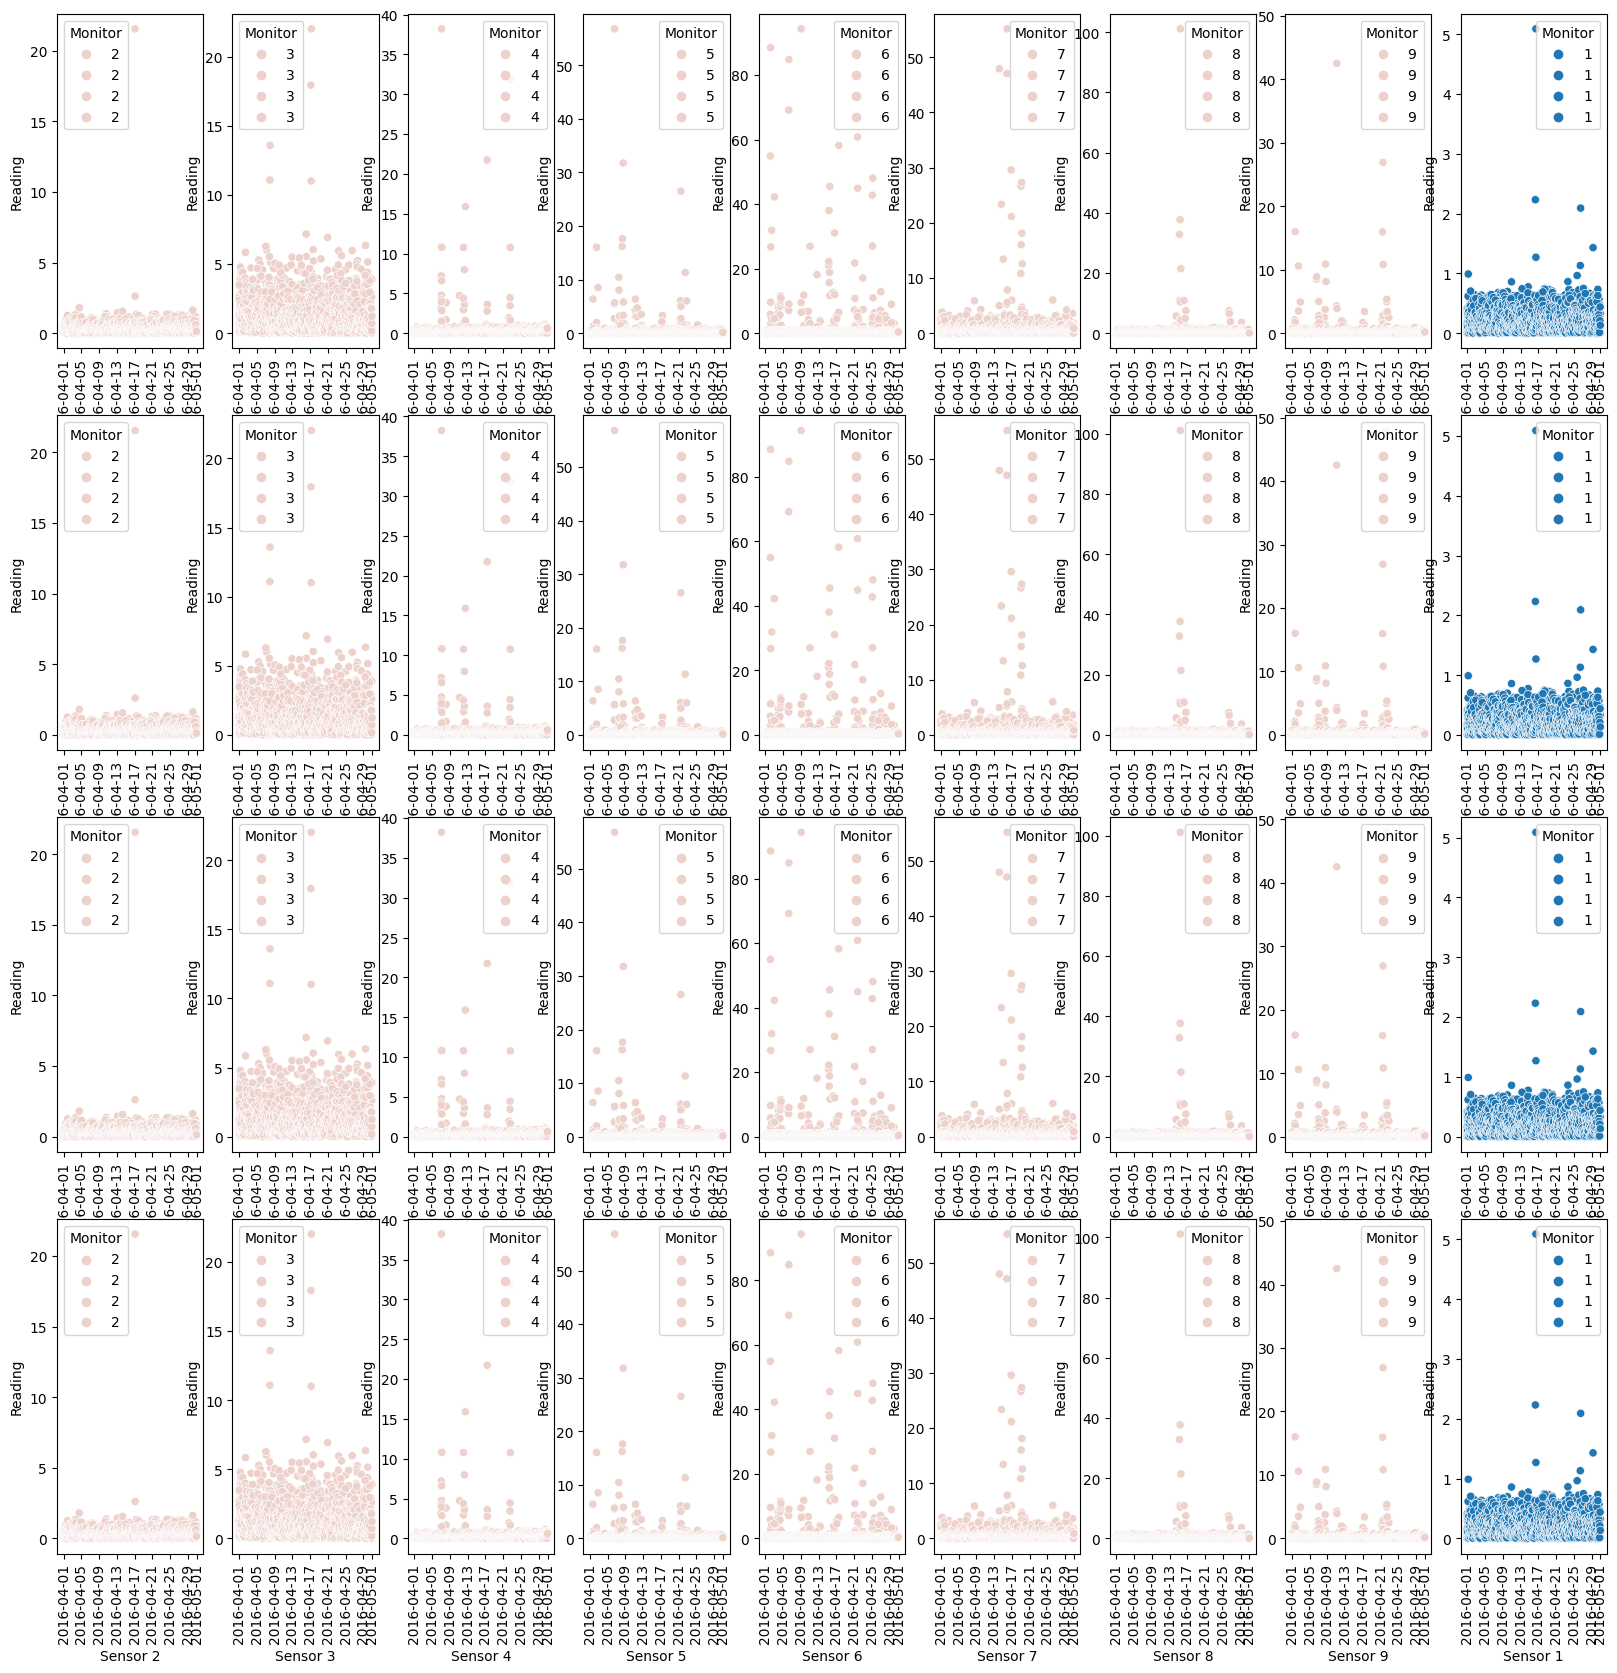

In [78]:
plt.figure(figsize=(20, 20))
chem_dict = {1:'Chlorodinine', 2:'Methylosmolene', 3:'AGOC-3A', 0:'Appluimonia'}
for i in range(1,37):
  for k in range(1, 5):
    plt.subplot(4,9,i)

    temp = apr_sensor[apr_sensor['Monitor']==i%9+1]
    c = k%4
    temp = temp[temp['Chemical']==chem_dict[c]]
    #apr_sensor
    sns.scatterplot(temp, x=temp['date'], y=temp['Reading'], hue =temp['Monitor'] )
    #titles = np.where(train['labels']==i)
    #index = titles[0][50]
    #plt.imshow(train['features'][index], cmap=plt.cm.binary)
    plt.xlabel(f'Sensor {i%9+1}')
    plt.xticks(rotation = 90)
plt.show()

In [79]:
from statistics import mean, median
sensor.groupby(['Monitor', 'Chemical']).agg({'Reading': [min, max, mean, median]}) #Reading

Reading                               
                             min        max      mean    median
Monitor Chemical                                               
1       AGOC-3A         0.001065   31.66583  0.247551  0.204751
        Appluimonia     0.001130    2.20189  0.234196  0.207819
        Chlorodinine    0.001015    5.09007  0.246517  0.217125
        Methylosmolene  0.001003   31.80997  0.244332  0.206787
2       AGOC-3A         0.001598   26.58683  0.379821  0.297561
        Appluimonia     0.001322    1.80374  0.358014  0.312735
        Chlorodinine    0.001633    7.46014  0.358775  0.303008
        Methylosmolene  0.001591   42.71211  0.391639  0.301542
3       AGOC-3A         0.001257   85.31459  1.604814  1.031770
        Appluimonia     0.001899    6.92741  1.262546  0.979943
        Chlorodinine    0.001661    8.96003  1.287194  1.011125
        Methylosmolene  0.002452   47.74763  1.377328  0.981951
4       AGOC-3A         0.001833   65.71898  1.506940  1.132690
        Appluimonia     0.001054    4.86055  1.136847  1.106710
        Chlorodinine    0.002067   14.58982  1.230909  1.125095
        Methylosmolene  0.001067   38.21998  1.232873  1.117135
5       AGOC-3A         0.001235   84.63599  0.927088  0.358368
        Appluimonia     0.001154    7.74279  0.462172  0.336965
        Chlorodinine    0.001040   11.74958  0.512913  0.329785
        Methylosmolene  0.001876   53.64960  0.550409  0.346014
6       AGOC-3A         0.001187   84.82578  1.329150  0.410961
        Appluimonia     0.003286    8.95095  0.419776  0.398960
        Chlorodinine    0.002921   15.04032  0.687027  0.414594
        Methylosmolene  0.001418  100.77640  0.988030  0.397912
7       AGOC-3A         0.001574   47.05521  0.698610  0.431402
        Appluimonia     0.002178    4.84236  0.603231  0.438515
        Chlorodinine    0.001124   13.40056  0.619989  0.428507
        Methylosmolene  0.001060   63.31599  0.742092  0.411834
8       AGOC-3A         0.001025  101.10558  0.568444  0.435373
        Appluimonia     0.001803    4.87418  0.475398  0.433945
        Chlorodinine    0.001076    7.44058  0.481509  0.418473
        Methylosmolene  0.001448   32.82523  0.494827  0.417768
9       AGOC-3A         0.001790   47.95602  0.715668  0.298013
        Appluimonia     0.001334    8.51651  0.428177  0.297018
        Chlorodinine    0.001216    5.03405  0.373929  0.286737
        Methylosmolene  0.001241   42.51119  0.423995  0.283902

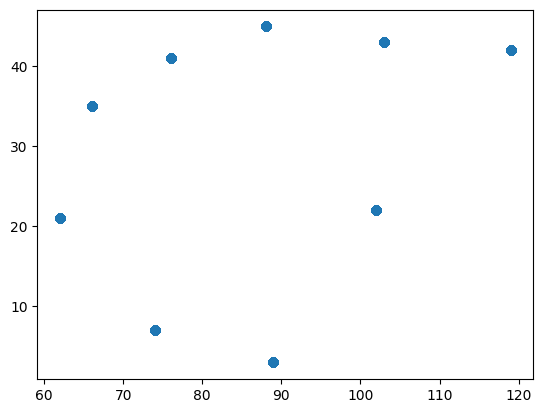

In [80]:
plt.scatter(x=sensor['x'], y=sensor['y'])
plt.show()

In [81]:
#Create DF of factory coordinates:
factories = {'Roadrunner':[89,27], 'Kasios': [90,21], 'Radiance':[109,26], 'Indigo':[120,22]}
fac = pd.DataFrame.from_dict(factories, orient='index')
fac.rename(columns = {0: 'x', 1:'y'}, inplace=True)
fac['Chemical'] =fac.index.tolist()
fac

x   y    Chemical
Roadrunner   89  27  Roadrunner
Kasios       90  21      Kasios
Radiance    109  26    Radiance
Indigo      120  22      Indigo

In [82]:
#fac.index.tolist()
sensor.head(2)

Chemical  Monitor       date  Reading   x   y   wind  wind_speed
0  Methylosmolene        3 2016-04-01  2.68382  76  41  190.5         4.0
1  Methylosmolene        7 2016-04-01  2.63064  89   3  190.5         4.0

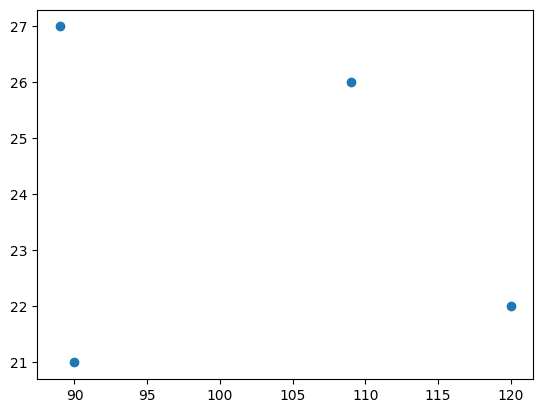

In [83]:
plt.scatter(x=fac['x'], y=fac['y'])
plt.show()

In [84]:
sensor.tail(2)

Chemical  Monitor                date   Reading   x  y   wind  \
79241  Appluimonia        7 2016-12-31 23:00:00  0.039729  89  3  161.0   
79242      AGOC-3A        7 2016-12-31 23:00:00  0.014658  89  3  161.0   

       wind_speed  
79241         3.5  
79242         3.5

In [85]:
#sensor['date'][0]

#Add factories to sensor df for graphical purposes
#sensor.loc[len(sensor.index)] = ['Roadrunner', 10, '2016-04-01 00:00:00', 10, 89,27 ]
#sensor.loc[len(sensor.index)] = ['Kasios', 10, '2016-04-01 00:00:00', 10, 90,21 ]
#sensor.loc[len(sensor.index)] = ['Indigo', 10, '2016-04-01 00:00:00', 10, 120,22 ]
#sensor.loc[len(sensor.index)] = ['Radiance', 10, '2016-04-01 00:00:00', 10, 109,22 ]

#Want to add all wind speeds for the factories so they show up in the plotly plots:
for i in range(0, 340, 30):
  sensor_graph = pd.concat([sensor,
                      pd.DataFrame({'Chemical':'Roadrunner', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':89,'y':27, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Kasios', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':90,'y':21, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Indigo', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':120,'y':22, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Radiance', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':109,'y':26, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)


  #sensor.append({'Chemical':'Roadrunner', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
  #                           'x':109,'y':22, 'wind': i, 'wind_speed':1 }, ignore_index=True)

  
  


In [86]:
sensor_graph.tail()

Chemical  Monitor                 date    Reading    x   y   wind  \
75964     AGOC-3A        7  2016-12-31 23:00:00   0.014658   89   3  161.0   
75965  Roadrunner       20  2016-04-01 00:00:00  20.000000   89  27  330.0   
75966      Kasios       20  2016-04-01 00:00:00  20.000000   90  21  330.0   
75967      Indigo       20  2016-04-01 00:00:00  20.000000  120  22  330.0   
75968    Radiance       20  2016-04-01 00:00:00  20.000000  109  26  330.0   

       wind_speed  
75964         3.5  
75965         1.0  
75966         1.0  
75967         1.0  
75968         1.0

In [87]:

#

In [88]:
#Round wind direction values to nearest 30 degrees:

#sensor_round = sensor.copy()
#sensor_round['wind'] = sensor_round['wind'].apply(lambda x: round(x/30)*30)

#combine 0 degrees and 360 degrees:
#sensor_round['wind'] = sensor_round['wind'].apply(lambda x: x*0 if(x==360) else x)
#sensor.tail()

In [104]:
app = JupyterDash()

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,
    html.Div([
        html.H6('Wind Direction'),
        dcc.RangeSlider(
            id='wind_direction-slider',
            min=0,
            max=sensor_graph['wind'].max(),
            step=10,
            value=[sensor_graph['wind'].min(),sensor_graph['wind'].max()])
    ]),
    html.Div([
        html.H6('Wind Speed'),
        dcc.RangeSlider(
            id='wind_speed-slider',
            min=0,
            max=sensor_graph['wind_speed'].max(),
            step=.5,
            value=[sensor_graph['wind_speed'].min(),sensor_graph['wind_speed'].max()])
    ])
])


@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='wind_direction-slider', component_property='value'),
    Input(component_id='wind_speed-slider', component_property='value'))

def update_figure(selected_wind, selected_speed):
    filtered_df = sensor_graph[(sensor_graph.wind >= selected_wind[0])&
                              (sensor_graph.wind <= selected_wind[1])&
                               (sensor_graph.wind_speed >= selected_speed[0])&
                               (sensor_graph.wind_speed <= selected_speed[1])]
    fig = px.scatter(filtered_df, x="x", y="y",
                 size="Reading", color="Chemical", hover_name="Chemical",
                 size_max=20, color_discrete_map={'Appluimonia': 'blue', 
                                                   'Chlorodinine': 'red', 
                                                  'Methylosmolene': 'yellow',
                                                  'AGOC-3A': 'green'})
    #color_discrete_sequence=px.colors.qualitative.Antique)
    fig.update_layout(transition_duration=100)
    return fig

app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

In [90]:

import plotly.graph_objects as go


# Load data
#df = pd.read_csv(
#    "https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv")
#df.columns = [col.replace("AAPL.", "") for col in df.columns]

df = sensor

# Create figure
fig = go.Figure()

fig.add_trace(
    #go.Scatter(x=list(df.Date), y=list(df.High)))
    go.Scatter(x=list(df.date), y=list(df.Reading)))


# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()#


In [91]:
sensor_graph['date'].iloc[-1] > sensor_graph['date'].iloc[-2]
#sensor_graph['date'].tail()
timedelta(hours=3)

datetime.timedelta(seconds=10800)

In [92]:
#d = (list(sensor.date))
#sensor['datestring'] = str(sensor['date'])
#sensor['datestring'] = sensor['date'].apply(lambda x: str(x))
#sensor.head()
sensor.head(10)

Chemical  Monitor       date   Reading    x   y   wind  wind_speed
0  Methylosmolene        3 2016-04-01  2.683820   76  41  190.5         4.0
1  Methylosmolene        7 2016-04-01  2.630640   89   3  190.5         4.0
2    Chlorodinine        3 2016-04-01  1.259170   76  41  190.5         4.0
3    Chlorodinine        7 2016-04-01  0.943983   89   3  190.5         4.0
4         AGOC-3A        3 2016-04-01  0.722303   76  41  190.5         4.0
5     Appluimonia        2 2016-04-01  0.518521   66  35  190.5         4.0
6     Appluimonia        8 2016-04-01  0.502186   74   7  190.5         4.0
7         AGOC-3A        7 2016-04-01  0.497282   89   3  190.5         4.0
8     Appluimonia        6 2016-04-01  0.458144  102  22  190.5         4.0
9  Methylosmolene        8 2016-04-01  0.456104   74   7  190.5         4.0

In [93]:
#sensor['datestring'][300]#<=sensor['datestring'][40000]
#sensor[0:10]
#sensor.iloc[0].date >= sensor['date'][2]

In [94]:
#sensor['datenum'] = [x for x in range(len(sensor['date'].unique()))]
#sensor['date'].apply(lambda x: str(x))
#sensor['date'].unique()

#Assign all dates to a numerical value:
l = list(sensor['date'].unique())
sensor['datenum']  = sensor['date'].apply(lambda x: l.index(x) )
  
#list(sensor['date'].unique()).index('2016-04-01T01:00:00.000000000')
sensor.sample(10)

Chemical  Monitor                date   Reading   x   y   wind  \
43279     Appluimonia        3 2016-08-21 07:00:00  0.829221  76  41  157.1   
22032         AGOC-3A        3 2016-04-26 14:00:00  2.685240  76  41   91.9   
3837     Chlorodinine        7 2016-04-05 11:00:00  0.212330  89   3  353.9   
3283          AGOC-3A        7 2016-04-04 20:00:00  0.551340  89   3  358.4   
39031     Appluimonia        3 2016-08-16 09:00:00  1.032590  76  41  173.7   
9754   Methylosmolene        7 2016-04-12 08:00:00  0.029896  89   3  174.8   
51908  Methylosmolene        7 2016-08-31 06:00:00  0.179172  89   3  171.2   
51329         AGOC-3A        8 2016-08-30 14:00:00  0.179592  74   7  202.9   
65071     Appluimonia        8 2016-12-15 14:00:00  0.789526  74   7  262.3   
40676         AGOC-3A        1 2016-08-18 06:00:00  0.100037  62  21  196.0   

       wind_speed  datenum  
43279         2.4     1114  
22032         0.7      612  
3837          1.2      106  
3283          1.2       91  
39031         0.5      996  
9754          2.2      270  
51908         1.0     1350  
51329         0.6     1334  
65071         2.5     1717  
40676         0.7     1041

In [95]:
#sensor['datenum'].unique()

In [106]:
#Add dropdowns for sensor and chemical and month!?

#https://stackoverflow.com/questions/69008518/plotly-dash-range-slider-with-datetime-and-scatterplot-interaction
#https://stackoverflow.com/questions/51063191/date-slider-with-plotly-dash-does-not-work
#

app = JupyterDash()

#transform every unique date to a number
#d = (list(sensor.date))
#d= [x for x in range(len(sensor['date'].unique()))]
d= [x for x in range(len(sensor['date']))]

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,
    html.Div([
            dcc.Dropdown(
                sensor['Monitor'].unique(),
                'Monitor (sensor)',
                id='monitor-selection'
            ),
        ], style={'width': '48%', 'display': 'inline-block'}),

    html.Div([
        html.H6('Date Range'),
        dcc.RangeSlider(
            id='date-slider',
            #min=0,
            min = sensor['datenum'].min(),
            #max=d[-1],
            max=sensor['datenum'].max(),
            step=10,
            #value=[sensor_graph['wind'].min(),sensor_graph['wind'].max()])
            #value=[0,d[-1]])
            value=[sensor['datenum'].min(),sensor['datenum'].max()])
    ]),
    

])


@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='date-slider', component_property='value'),
    Input(component_id='monitor-selection', component_property='value')
)

#def update_figure(selected_date, selected_monitor):
def update_figure(selected_date, selected_monitor):
    
    #filtered_df = filtered_df[(filtered_df.date >= filtered_df.iloc(selected_date[0]).date) &
    #                           (filtered_df.date <= filtered_df.iloc(selected_date[-1]).date)]
    
    filtered_df = sensor[(sensor.datenum >= selected_date[0]) & (sensor.datenum <= selected_date[1]) & 
                         (sensor.Monitor == selected_monitor)]
    
    #filtered_df = sensor[(sensor.Monitor == selected_monitor)]

                               #(sensor_graph.wind_speed >= selected_speed[0])&
                               #(sensor_graph.wind_speed <= selected_speed[1])]
    fig = px.scatter(filtered_df, x="date", y="Reading", color='Chemical',
                     color_discrete_map={'Appluimonia': 'blue', 
                                         'Chlorodinine': 'red',
                                         'Methylosmolene': 'yellow',
                                         'AGOC-3A': 'green'})
    
                 #size="Reading", color="Chemical", hover_name="Monitor")#,
                 #size_max=20, 
    #color_discrete_sequence=px.colors.qualitative.Antique)

    fig.update_layout(transition_duration=100)
    #fig.update_xaxes(rangeslider_visible=True)

    return fig

app.run_server(mode='inline')


Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

In [97]:
'''
#Add dropdowns for sensor and chemical and month!?

#https://stackoverflow.com/questions/69008518/plotly-dash-range-slider-with-datetime-and-scatterplot-interaction
#https://stackoverflow.com/questions/51063191/date-slider-with-plotly-dash-does-not-work
#

app = JupyterDash()

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,

])


@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='date-slider', component_property='value'))

def update_figure(selected_date):
    filtered_df = sensor[(sensor.datestring >= selected_date[0])&
                              (sensor.datestring <= selected_date[-1])]
                               #(sensor_graph.wind_speed >= selected_speed[0])&
                               #(sensor_graph.wind_speed <= selected_speed[1])]
    fig = px.scatter(filtered_df, x="date", y="Reading")#, #THIS SHOULD NOT MONITOR??!!!
                 #size="Reading", color="Chemical", hover_name="Monitor")#,
                 #size_max=20, color_discrete_map={'Appluimonia': 'blue', 
                 #                                  'Chlorodinine': 'red', 
                 #                                 'Methylosmolene': 'yellow',
                 #                                 'AGOC-3A': 'green'})
    #color_discrete_sequence=px.colors.qualitative.Antique)

    fig.update_layout(transition_duration=100)
    fig.update_xaxes(rangeslider_visible=True)
    
    return fig

app.run_server(mode='inline')
'''

'\n#Add dropdowns for sensor and chemical and month!?\n\n#https://stackoverflow.com/questions/69008518/plotly-dash-range-slider-with-datetime-and-scatterplot-interaction\n#https://stackoverflow.com/questions/51063191/date-slider-with-plotly-dash-does-not-work\n#\n\napp = JupyterDash()\n\napp.layout = html.Div(children = [\n    html.Div([\n        dcc.Graph(id=\'graph-with-slider\'),\n    ]) ,\n\n])\n\n\n@app.callback(\n    Output(component_id=\'graph-with-slider\', component_property=\'figure\'),\n    Input(component_id=\'date-slider\', component_property=\'value\'))\n\ndef update_figure(selected_date):\n    filtered_df = sensor[(sensor.datestring >= selected_date[0])&\n                              (sensor.datestring <= selected_date[-1])]\n                               #(sensor_graph.wind_speed >= selected_speed[0])&\n                               #(sensor_graph.wind_speed <= selected_speed[1])]\n    fig = px.scatter(filtered_df, x="date", y="Reading")#, #THIS SHOULD NOT MONITOR??!

In [98]:
#sns.scatterplot(data=apr_sensor, x='wind_speed', y='Reading', hue=None)
#Plot bar graph of price v. make:
#sns.barplot(x='Monitor', y="Reading", data=sensor, order=sensor['Monitor'])
#plt.set_title('Make v. Price')
#plt.set_xlabel('Make')
#plt.set_ylabel('Price')
#plt.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
#plt.show()

In [99]:
#Run regression model, after model compiled, run predictions for all and compare against actual values

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Split the data (70/30):
X = sensor.drop(columns = ['Reading', 'x', 'y', 'date', 'Chemical']).copy()
y = sensor['Reading'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)
#y_pred = y_pred.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)
mean_squared_error(y_test, y_pred)

4.841047088494404

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

reg_dt = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
#cross_val_score(reg_dt, X, y, cv=10)
y_pred_dt = reg_dt.predict(X_test)
mean_squared_error(y_test, y_pred_dt)

6.481312571296642

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py in __nonzero__(
    self=0        True
1        True
2        True
3     ...   True
Name: datenum, Length: 75965, dtype: bool
)
   1525     @final
   1526     def __nonzero__(self) -> NoReturn:
-> 1527         raise ValueError(
        global ValueError = undefined
   1528             f"The truth value of a {type(self).__name__} is ambiguous. "
   1529             "Use a.empty, a.bool(), a.item(), a.any() or a.all()."

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().



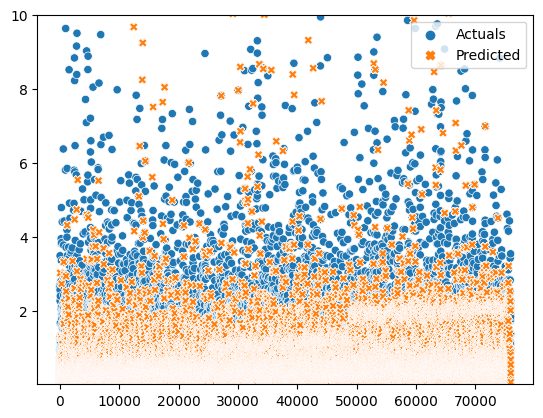

In [101]:
y_pred = reg_dt.predict(X)
test = pd.DataFrame(y.values, columns=['Actuals'])
test['Predicted'] = y_pred
sns.scatterplot(data=test)#, x='wind_speed', y='Reading', hue=None)
#test.head()
plt.ylim(bottom = .01,top=10)
plt.show()